# GMDL 222 -  Deep Learning Practical Session 2

1.   Introduction to Convolutional Neural Network. 
2.   Transfer Learning. 
3.   Residual Net. 
4.   Train ants and bees classifier using transfer learning from ResNet. 

Transfer learning tutorial from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



These two major transfer learning scenarios look as follows:

1. **Finetuning ResNet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
2. **ResNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Setup
The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. 

This dataset is a very small subset of imagenet.

But first we will load the data from our google drive!

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# Your path goes here:
base_path = 'gdrive/MyDrive/DeepLearning/bees_and_ants/'

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation. Center crop is a popular method 
# to 'resize' the input images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = base_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
def eval_model(model, val_loader, device="cuda"):
  correct_count, all_count = 0, 0
  with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct_pred = torch.eq(labels, preds).cpu()
        correct_count += correct_pred.numpy().sum()
        all_count += len(labels)

  print("Number Of Images Tested =", all_count)
  print("\nModel Accuracy =", (correct_count/all_count))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


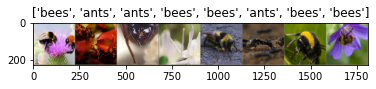

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training procedure

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    softmax = nn.Softmax(dim=1)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # logits: The raw predictions from the last layer
                    logits = model(inputs)
                    _, preds = torch.max(logits, 1)
                    # using CE criterion, thus input is the logits
                    loss = criterion(logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            if phase == 'train':
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))

            # deep copy the model the best accuracy based on the validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Simple **ConvNet**

### The convolution operation

![image.png](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size)
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # FC layers - since we use global avg pooling,
        #  input to the FC layer = #output_features of the second conv layer
        self.fc1 = nn.Linear(16, 64)  # 5*5 from image dimension
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # adaptive_avg_pool2d with output_size=1 = simple global avg pooling
        x = F.adaptive_avg_pool2d(F.relu(self.conv2(x)), 1)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        # note: no softmax
        x = self.fc2(x)
        return x


convNet = ConvNet()
print(convNet)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


### Train CNN

In [10]:
# CE loss, therefor input should be logits 
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_cnn = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cnn, step_size=10, gamma=0.1)
convNet = convNet.to(device)

convNet = train_model(convNet, criterion, optimizer_cnn, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6948 Acc: 0.5041

Epoch 1/24
----------
train Loss: 0.6945 Acc: 0.4836

Epoch 2/24
----------
train Loss: 0.6937 Acc: 0.5041

Epoch 3/24
----------
train Loss: 0.6944 Acc: 0.4344

Epoch 4/24
----------
train Loss: 0.6925 Acc: 0.5615

Epoch 5/24
----------
train Loss: 0.6913 Acc: 0.5328

Epoch 6/24
----------
train Loss: 0.6922 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.6897 Acc: 0.5697

Epoch 8/24
----------
train Loss: 0.6888 Acc: 0.5369

Epoch 9/24
----------
train Loss: 0.6877 Acc: 0.5533

Epoch 10/24
----------
train Loss: 0.6874 Acc: 0.5656

Epoch 11/24
----------
train Loss: 0.6869 Acc: 0.5574

Epoch 12/24
----------
train Loss: 0.6866 Acc: 0.5615

Epoch 13/24
----------
train Loss: 0.6864 Acc: 0.5615

Epoch 14/24
----------
train Loss: 0.6870 Acc: 0.5697

Epoch 15/24
----------
train Loss: 0.6852 Acc: 0.6025

Epoch 16/24
----------
train Loss: 0.6874 Acc: 0.5410

Epoch 17/24
----------
train Loss: 0.6861 Acc: 0.5738

Epoch 18/24
----------
train Loss: 0.6877 

In [11]:
eval_model(convNet, dataloaders["val"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number Of Images Tested = 153

Model Accuracy = 0.5098039215686274


# ResNet
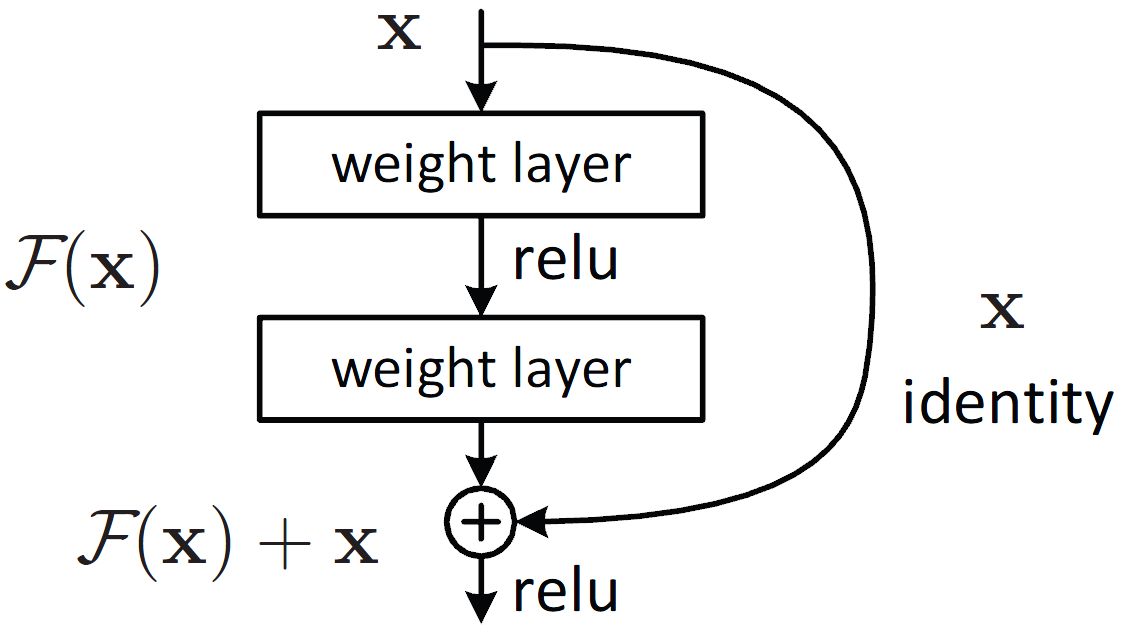

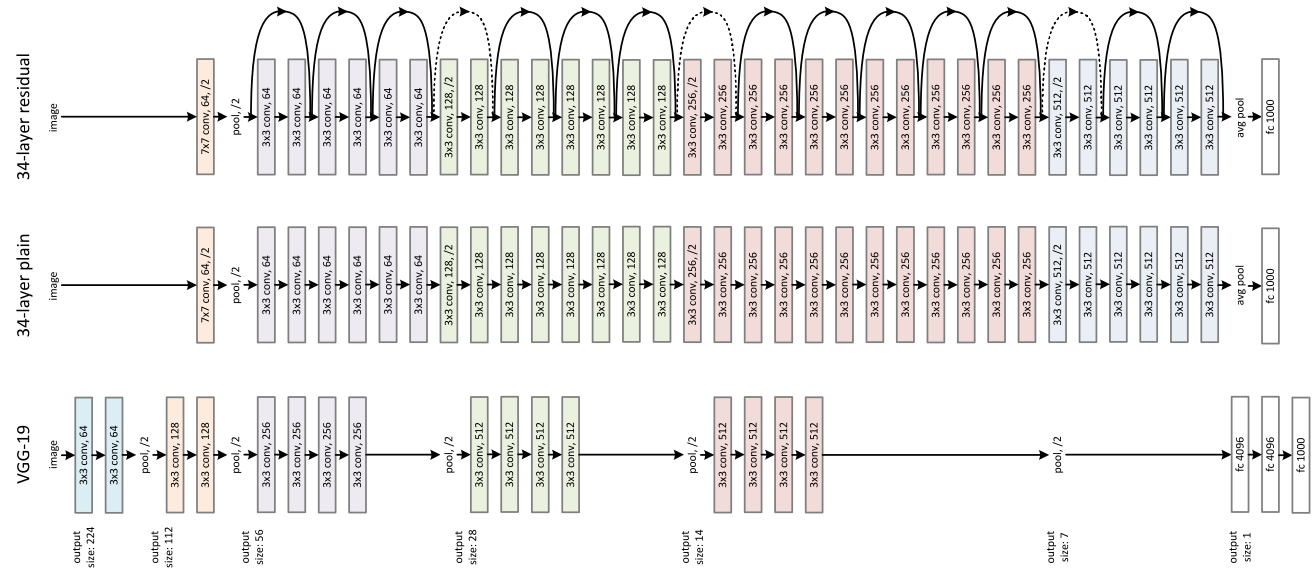

## Finetuning **ResNet18**
Load a pretrained model and reset final fully connected layer. 
As mentioned earlier, instead of random initializaion, we initialize the network with a pretrained network (on ImageNet). 

Q: Why did we have to reset the final FC layer?

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
# another way to print our model outline + #parameters
from torchsummary import summary
# [3, 224, 224]
input_shape = image_datasets['train'][0][0].shape
summary(model_ft, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Train and evaluate:
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5751 Acc: 0.6721

Epoch 1/24
----------
train Loss: 0.2502 Acc: 0.8975

Epoch 2/24
----------
train Loss: 0.2514 Acc: 0.8975

Epoch 3/24
----------
train Loss: 0.2633 Acc: 0.8730

Epoch 4/24
----------
train Loss: 0.2408 Acc: 0.9180

Epoch 5/24
----------
train Loss: 0.2694 Acc: 0.8811

Epoch 6/24
----------
train Loss: 0.1944 Acc: 0.9139

Epoch 7/24
----------
train Loss: 0.2512 Acc: 0.8934

Epoch 8/24
----------
train Loss: 0.1391 Acc: 0.9426

Epoch 9/24
----------
train Loss: 0.2355 Acc: 0.9139

Epoch 10/24
----------
train Loss: 0.0889 Acc: 0.9713

Epoch 11/24
----------
train Loss: 0.1537 Acc: 0.9549

Epoch 12/24
----------
train Loss: 0.1298 Acc: 0.9467

Epoch 13/24
----------
train Loss: 0.1354 Acc: 0.9385

Epoch 14/24
----------
train Loss: 0.1158 Acc: 0.9590

Epoch 15/24
----------
train Loss: 0.1744 Acc: 0.9385

Epoch 16/24
----------
train Loss: 0.1227 Acc: 0.9426

Epoch 17/24
----------
train Loss: 0.1203 Acc: 0.9508

Epoch 18/24
----------
train Loss: 0.1382 

In [15]:
PATH = './finetuning_net.pth'
torch.save(model_ft.state_dict(), PATH)

In [16]:
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model_ft(inputs)
_, preds = torch.max(outputs, 1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


labels: 0 - ants, 1 - bees
original label: tensor(0, device='cuda:0')
predicted labels: tensor([-1.0367,  1.1260], device='cuda:0', grad_fn=<SelectBackward0>)
------------------------------------------------


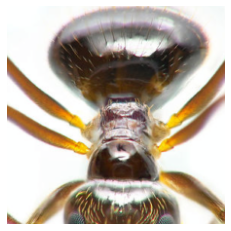

In [18]:
j = 3

plt.axis('off')
print("labels: 0 - ants, 1 - bees")
print("original label:", labels[j])
print("predicted labels:", outputs[j])
print("------------------------------------------------")
imshow(inputs.cpu().data[j])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


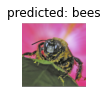

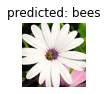

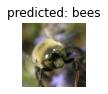

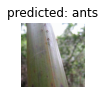

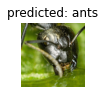

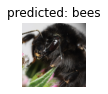

In [19]:
visualize_model(model_ft)

In [20]:
eval_model(model_ft, dataloaders["val"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number Of Images Tested = 153

Model Accuracy = 0.954248366013072


## ResNet18 as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

Q: what is the key differnce between this and the previous transfer learning method?

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [22]:
print(model_conv.fc)

Linear(in_features=512, out_features=2, bias=True)


Train and evaluate


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6103 Acc: 0.6393

Epoch 1/24
----------
train Loss: 0.3755 Acc: 0.8279

Epoch 2/24
----------
train Loss: 0.3618 Acc: 0.8402

Epoch 3/24
----------
train Loss: 0.3283 Acc: 0.8525

Epoch 4/24
----------
train Loss: 0.3006 Acc: 0.8607

Epoch 5/24
----------
train Loss: 0.3573 Acc: 0.8607

Epoch 6/24
----------
train Loss: 0.3492 Acc: 0.8402

Epoch 7/24
----------
train Loss: 0.2892 Acc: 0.8730

Epoch 8/24
----------
train Loss: 0.2306 Acc: 0.9098

Epoch 9/24
----------
train Loss: 0.2216 Acc: 0.9016

Epoch 10/24
----------
train Loss: 0.2701 Acc: 0.8852

Epoch 11/24
----------
train Loss: 0.2281 Acc: 0.9016

Epoch 12/24
----------
train Loss: 0.2623 Acc: 0.8893

Epoch 13/24
----------
train Loss: 0.2321 Acc: 0.8893

Epoch 14/24
----------
train Loss: 0.2461 Acc: 0.9016

Epoch 15/24
----------
train Loss: 0.2625 Acc: 0.8811

Epoch 16/24
----------
train Loss: 0.2003 Acc: 0.9344

Epoch 17/24
----------
train Loss: 0.2417 Acc: 0.8934

Epoch 18/24
----------
train Loss: 0.1817 

In [ ]:
PATH1 = './feature_net.pth'
torch.save(model_conv.state_dict(), PATH1)

In [ ]:
model_conv.load_state_dict(torch.load(PATH1))

<All keys matched successfully>

In [ ]:
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model_conv(inputs)
_, preds = torch.max(outputs, 1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


labels: 0 - ants, 1 - bees
original label: tensor(0, device='cuda:0')
predicted labels: tensor([ 1.6057, -2.1803], device='cuda:0', grad_fn=<SelectBackward0>)
------------------------------------------------


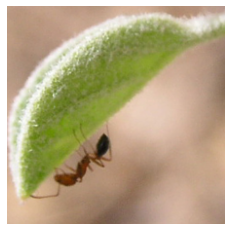

In [ ]:
j = 1

plt.axis('off')
print("labels: 0 - ants, 1 - bees")
print("original label:", labels[j])
print("predicted labels:", outputs[j])
print("------------------------------------------------")
imshow(inputs.cpu().data[j])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


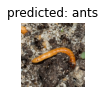

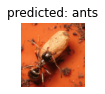

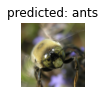

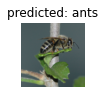

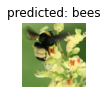

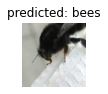

In [ ]:
visualize_model(model_conv)

In [ ]:
eval_model(model_conv, dataloaders["val"])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number Of Images Tested = 153

Model Accuracy = 0.954248366013072
